In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import pandas as pd

In [167]:
methods = ["MMD", "MMD OCSVM Verify", "OCSVM"]
model_types = {"kernel=\'linear\'" : "linear", "SVR(":"non-linear", "LinearRegression" : "LReg"}
kernel_colors = {"linear" : "r", "non-linear" : "b", "LReg" : "o", "combined" : "g"}
colors = ["bo", "go", "ro", "co", "mo", "yo", "ko"]
direction_markers = [9, 8]
method_markers = {"MMD" : "." , "OCSVM" : "$O$"}
marker_meaning = {"1" : "forward", "2" : "backwards"}
normalized = {True : "-std", False: ""}
alpha_norm = {True : 1/3, False: 2/3}

In [81]:
def sort_similar_pairs(df):
    n_pairs =  int(df.shape[0]/2)
    
    for pair_index in range(n_pairs):
        pair = df.iloc[pair_index*2].copy()
        backwards_pair =  df.loc[(df.test_node == pair.model_node) & 
                                (df.model_node == pair.test_node)]

        if pair_index*2+1 != backwards_pair.index:
            misplaced_pair = df.loc[pair_index*2+1]
            df.iloc[backwards_pair.index] = misplaced_pair
            df.iloc[pair_index*2+1] = backwards_pair

        if pair.model_node > pair.test_node:
            df.iloc[pair_index*2] = backwards_pair
            df.iloc[pair_index*2+1] = pair

    similar_pairs = [pair for pair in df.values]
    
    return similar_pairs

def get_pair_df(pair, df):
    forward_match = ((df.model_node==pair[0])&(df.test_node==pair[1]))
    backward_match = ((df.model_node==pair[1])&(df.test_node==pair[0]))
    regex_model_types = "|".join(["kernel=\'linear\'", "SVR"])
    model_type_match = (df.model.str.contains(regex_model_types, regex=True))
    forward_df = df.loc[forward_match & model_type_match]
    backward_df = df.loc[backward_match & model_type_match]
    return {str((pair[0], pair[1])) : forward_df, str((pair[1], pair[0])) : backward_df}

def get_linear_non_linear_df(df):
    df_linear = df.loc[df.model.str.contains("kernel=\'linear\'")]
    df_non_linear = pd.concat([df,df_linear]).drop_duplicates(keep=False)
    return df_linear, df_non_linear

In [195]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def plot_r2_discrpenacy(sample_id, data, omit_bad_pairs=False):
    stats = {}
        
    for experiment in range(1,4):
        experiment_stats = pd.DataFrame(columns = data.discrepancy.describe().index)
        df = data.loc[(data.experiment==experiment)]
        unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False))) 
        similar_pairs = sort_similar_pairs(unique_pairs_df)
        pair_dfs = [get_pair_df(pair, df) for pair in similar_pairs[::2]]

        if omit_bad_pairs:
            pair_dfs = [pair_df for pair_df in pair_dfs 
                        if list(pair_df.values())[0].discrepancy.min() < 1 or list(pair_df.values())[1].discrepancy.min() < 1]
        
        n_pairs = len(pair_dfs)
        
        xlabel = "Discrepancy"
        ylabel = "Coefficient of Determination"
        
        for pair_index in range(n_pairs):
            forward_pair, backward_pair = pair_dfs[pair_index].keys()
            forward_df, backward_df = pair_dfs[pair_index].values()
            pair_df = pd.concat([forward_df, backward_df])
            
            fig, axs = plt.subplots(nrows = 1, ncols = 1, sharey="row", sharex= "row", figsize= (6, 3.5))
            fig.suptitle(forward_pair, fontsize =13)
            fig.tight_layout(pad=1.0)
            
            method = pd.unique(pair_df.method)[0]
            experiment_stats.loc[forward_pair] = forward_df.loc[(forward_df.method==method)&
                                                                (forward_df["sample pair calculation"]==True)].discrepancy.describe().values.T
            experiment_stats.loc[backward_pair] = backward_df.loc[(backward_df.method==method)&
                                                                  (backward_df["sample pair calculation"]==True)].discrepancy.describe().values.T
            
            sub_pair_df = pair_df.loc[(pair_df.method != "MMD OCSVM Verify")&(pair_df["sample pair calculation"]==True)]
            if len(pd.unique(sub_pair_df.method)) == 2:
                
            for row in sub_pair_df.itertuples(index=False):
                model_type = [model_types[m] for m in model_types if m in row.model][0]
                color = kernel_colors[model_type]
                x, y = round(row.discrepancy,2), round(row.score,2)

                if row.model_node < row.test_node:
                    direction = 0
                else:
                    direction = 1 
                axs.plot(x, y, "w", alpha = 0.5, marker = method_markers[row.method])
                axs.plot(x, y, color, alpha = 0.5, marker = direction_markers[direction])
            

#             axs[0].set_title(forward_pair, fontsize=10)
#             axs[1].set_title(backward_pair, fontsize=10)
            axs.set_ylabel(ylabel)
            axs.set_xlabel(xlabel)
            axs.set_ylim([0,1.0])

#             [(,  for i in range(1)]
            if omit_bad_pairs:
                axs.set_xlim([0,1.0])
#                 axs[1].set_xlim([0,1.0])
        
            d = df[["model_node", "test_node"]].values
            x = d[:,0]
            y = d[:,1]
            kernel_lines = [Line2D(x, y, c= kernel_colors[k], alpha = 2/3, linewidth=5) for k in ["linear","non-linear"]]
    #         std_lines = [Line2D(x, y, c= "r", alpha = alpha_norm[True], linewidth = 5)]
            direction_lines = [(Line2D(x, y, c= "b", alpha = 0.5, marker = method_markers[method], linewidth = 0),
                                Line2D(x, y, c= "b", alpha = 0.5, marker = ">", linewidth = 0)) 
                               for method in pd.unique(sub_pair_df.method)]

            lines = kernel_lines + direction_lines
            text = ["linear", "non-linear"]
            for method in pd.unique(sub_pair_df.method):
                thresholds = sub_pair_df.loc[sub_pair_df.method==method].threshold
                if method == "MMD":
                    text.append(f"{method}({thresholds.values[0]})")
                else:
                    thresholds = pd.unique(thresholds)
                    text.append(f"{method}(> : {thresholds[0]}, < :{thresholds[1]})")

            plt.legend(lines, text)
    #         plt.savefig(f"results/figures/{sample_id}/experiment_{experiment}.png")
            plt.show()
        
        stats[experiment] = experiment_stats
    return stats

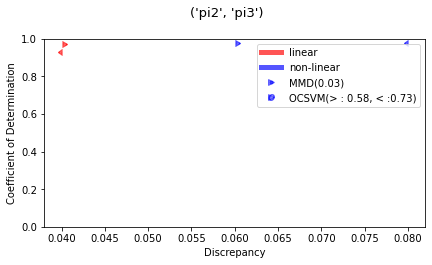

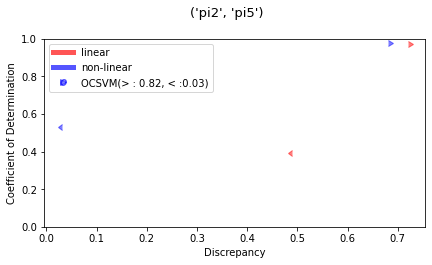

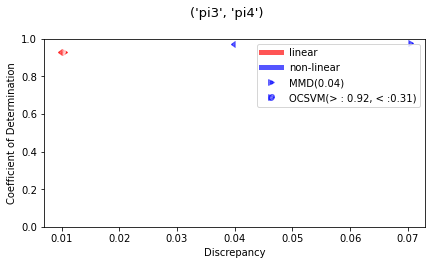

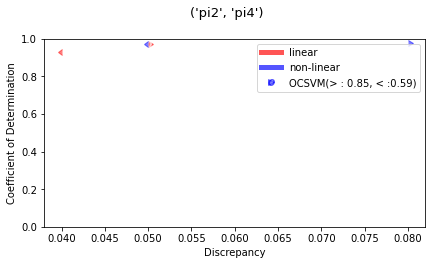

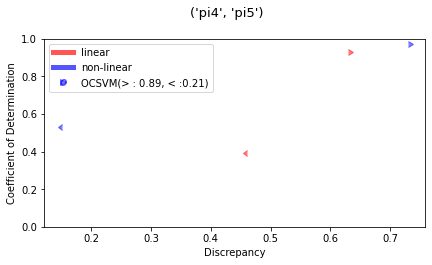

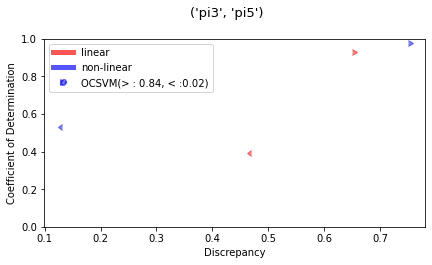

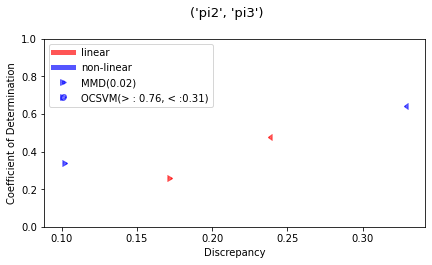

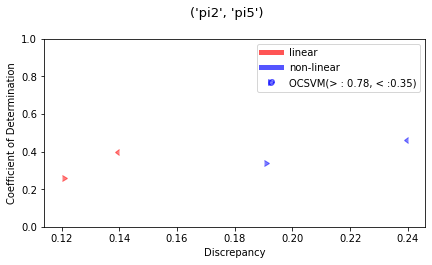

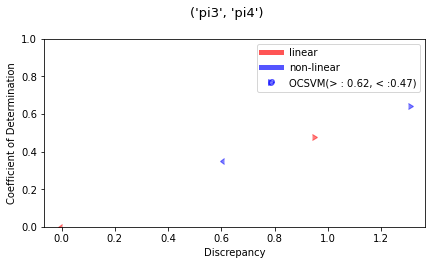

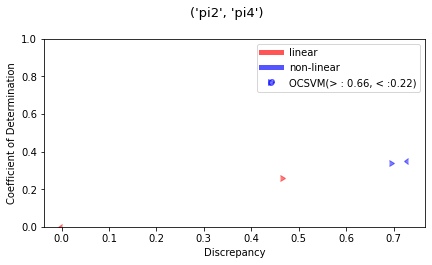

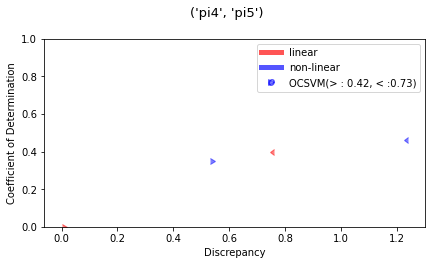

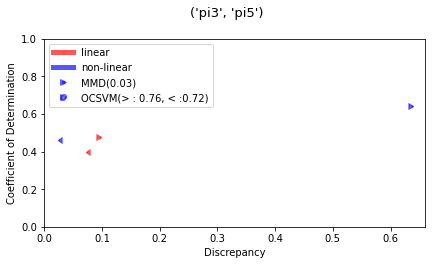

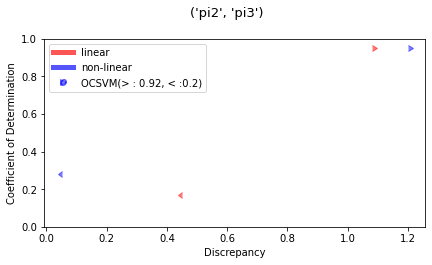

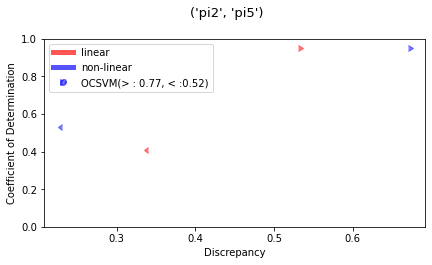

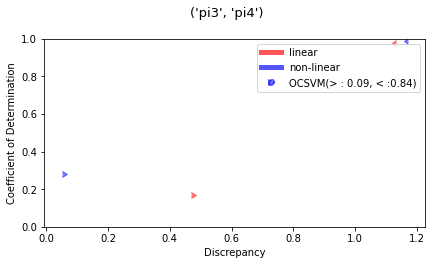

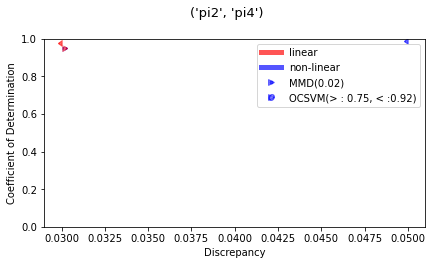

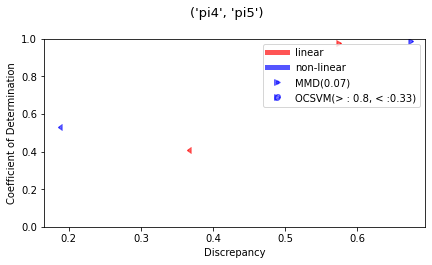

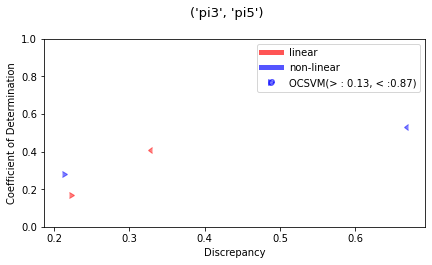

In [196]:
sample_id = f"sample_{1}"
sample_1 = pd.read_csv(f"results/standardised/{sample_id}.csv") 
sample_1_stats = plot_r2_discrpenacy(sample_id, sample_1, omit_bad_pairs=False)

In [8]:
stats[1]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi4')",4.0,0.081252,0.021946,0.061099,0.063153,0.080007,0.098106,0.103896
"('pi4', 'pi2')",4.0,0.060082,0.016682,0.048554,0.051342,0.053478,0.062218,0.084817
"('pi3', 'pi5')",4.0,1.226323,0.027013,1.208625,1.211367,1.215119,1.230075,1.266431
"('pi5', 'pi3')",4.0,0.353912,0.419939,0.022771,0.103264,0.216690,0.467338,0.959498
"('pi3', 'pi4')",4.0,2.197870,1.893543,0.557255,0.558444,2.190767,3.830193,3.852689
"('pi4', 'pi3')",4.0,0.197272,0.104515,0.091397,0.117281,0.196142,0.276132,0.305407


In [64]:
sample_id = f"sample_{1}"
sample_2 = pd.read_csv(f"results/standardised/{sample_id}.csv")
sample_2.loc[(sample_2.experiment ==3)&(sample_2.method=="OCSVM")&(sample_2.model_node=="pi2")]

,model_node,model,score,test_node,discrepancy,method,threshold,sample pair calculation,experiment,std
152,pi2,SVR(C=100),0.95,pi3,1.20,OCSVM,0.92,True,3,True
153,pi2,SVR(C=100),0.95,pi4,0.03,OCSVM,0.75,True,3,True
154,pi2,SVR(C=100),0.95,pi5,0.67,OCSVM,0.77,True,3,True
164,pi2,SVR(kernel='linear'),0.95,pi3,1.08,OCSVM,0.92,True,3,True
165,pi2,SVR(kernel='linear'),0.95,pi4,0.03,OCSVM,0.75,True,3,True
166,pi2,SVR(kernel='linear'),0.95,pi5,0.53,OCSVM,0.77,True,3,True
184,pi2,SVR(C=100),0.95,pi3,1.20,OCSVM,0.96,False,3,True
185,pi2,SVR(C=100),0.95,pi4,0.03,OCSVM,0.79,False,3,True
186,pi2,SVR(C=100),0.95,pi5,0.67,OCSVM,0.84,False,3,True
196,pi2,SVR(kernel='linear'),0.95,pi3,1.08,OCSVM,0.96,False,3,True


In [9]:
stats[2]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi4')",4.0,0.708675,0.158423,0.531848,0.596834,0.724773,0.836615,0.853305
"('pi4', 'pi2')",4.0,4.248408,4.462332,0.308845,0.423603,4.222764,8.047569,8.239260
"('pi3', 'pi4')",4.0,4.911711,0.301306,4.559934,4.779625,4.897738,5.029825,5.291433
"('pi4', 'pi3')",4.0,7.507418,0.412345,7.085203,7.205390,7.487124,7.789152,7.970221
"('pi2', 'pi5')",4.0,32.092114,0.682431,31.148771,31.886420,32.227441,32.433136,32.764804
"('pi5', 'pi2')",4.0,19.735039,0.297232,19.300334,19.676225,19.838374,19.897188,19.963072
"('pi4', 'pi5')",4.0,24.233466,16.513910,10.079254,10.350095,22.172853,36.056225,42.508905
"('pi5', 'pi4')",4.0,4.005234,0.221234,3.700537,3.934380,4.048433,4.119287,4.223531
"('pi3', 'pi5')",4.0,0.669661,0.407736,0.119309,0.511760,0.740889,0.898790,1.077558
"('pi5', 'pi3')",4.0,0.561090,0.212016,0.368394,0.382527,0.559497,0.738060,0.756971


In [10]:
stats[3]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi4')",4.0,1.293767,1.455307,0.012577,0.046188,1.262229,2.509808,2.638034
"('pi4', 'pi2')",4.0,1.153722,1.661858,0.073174,0.079686,0.480208,1.554244,3.581297
"('pi3', 'pi5')",4.0,4.501849,0.140222,4.330750,4.416085,4.523777,4.609540,4.629091
"('pi5', 'pi3')",4.0,147.145884,5.958422,140.374661,145.083359,146.652934,148.715459,154.903005
"('pi3', 'pi4')",4.0,0.182417,0.146898,0.083044,0.103816,0.123107,0.201708,0.400410
"('pi4', 'pi3')",4.0,2.242956,0.511341,1.732038,1.838456,2.276260,2.680760,2.687265


In [45]:
samples = {}
for sample_id in range(1,5):
    sample = pd.read_csv(f"results/standardised/sample_{sample_id}.csv")
    experiment_data = {}
    for experiment in range(1,4):
        experiment_similar_pairs  = ""
        for method in methods:
            df = data.loc[(sample.experiment==experiment)&(data.method==method)&(data["sample pair calculation"]==False)]
            unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False)))
            similar_pairs = sort_similar_pairs(unique_pairs_df)
            experiment_similar_pairs += str(similar_pairs[::2])
        experiment_data[experiment] = experiment_similar_pairs
    samples[f"sample_{sample_id}"] = experiment_data

In [46]:
samples["sample_1"] == samples["sample_2"] == samples["sample_3"] == samples["sample_4"]       

False

In [49]:
samples["sample_2"]

{1: "[][][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi5'], dtype=object), array(['pi3', 'pi4'], dtype=object)]",
 2: "[][array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi5'], dtype=object), array(['pi3', 'pi4'], dtype=object)]",
 3: '[][][]'}

In [48]:
samples["sample_1"]

{1: "[][][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi5'], dtype=object), array(['pi3', 'pi4'], dtype=object)]",
 2: "[][array(['pi2', 'pi4'], dtype=object)][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi5'], dtype=object), array(['pi3', 'pi4'], dtype=object)]",
 3: "[][][array(['pi2', 'pi4'], dtype=object), array(['pi3', 'pi4'], dtype=object), array(['pi2', 'pi5'], dtype=object), array(['pi4', 'pi5'], dtype=object), array(['pi3', 'pi5'], dtype=object)]"}